In [2]:
!pip install -U sentence-transformers

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [5]:
# os.chdir('..')
os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [6]:
from fashion_recommendations.metrics.average_precision import mapk

In [7]:
pd.options.display.max_columns = None

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Load transactions

In [9]:
train_set_orig = pd.read_csv('data/splits/train_subset.tsv', sep='\t', dtype={'article_id': str}, usecols=['t_dat', 'customer_id', 'article_id'])
print(train_set_orig.shape)
train_set_orig.head()

(588758, 3)


,t_dat,customer_id,article_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023
2,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0650193004
3,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0527687006
4,2018-09-20,02bfe1a5248beb9cd28ad4ac630a6d75e78d9a3e14551a...,0668767002


In [10]:
test_set = pd.read_csv('data/splits/test_subset.tsv', sep='\t', dtype={'article_id': str}, usecols=['t_dat', 'customer_id', 'article_id'])
print(test_set.shape)
test_set.head()

(32995, 3)


,t_dat,customer_id,article_id
0,2020-09-15,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007
1,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010
2,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010
3,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0610776105
4,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0929745001


Only include articles bought after 2020-01

In [11]:
train_set_orig['t_dat'] = pd.to_datetime(train_set_orig['t_dat'])

In [12]:
article_id_to_keep = train_set_orig[train_set_orig['t_dat'] > '2020-08-01']['article_id'].unique()
len(article_id_to_keep)

11270

In [13]:
print(train_set_orig.shape)
train_set_orig = train_set_orig.copy()[train_set_orig['article_id'].isin(article_id_to_keep)]
print(train_set_orig.shape)

(588758, 3)
(202947, 3)


### Load customer features

In [14]:
customers = pd.read_csv('data/customers.csv')
print(customers.shape)
customers.head()

(1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [15]:
customers.isnull().sum() / customers.shape[0]

customer_id               0.000000
FN                        0.652378
Active                    0.661508
club_member_status        0.004418
fashion_news_frequency    0.011669
age                       0.011561
postal_code               0.000000
dtype: float64

In [16]:
customers[['FN', 'Active']] = customers[['FN', 'Active']].fillna(0)

In [17]:
customers['club_member_status'] = customers['club_member_status'].str.lower().str.replace('-', '_').str.replace(' ', '_').fillna('missing')

In [18]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].str.lower().str.replace('-', '_').str.replace(' ', '_').fillna('missing')

In [19]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace('none', 'missing')

In [20]:
customers.isnull().sum()

customer_id                   0
FN                            0
Active                        0
club_member_status            0
fashion_news_frequency        0
age                       15861
postal_code                   0
dtype: int64

`customer_id` to indices

In [21]:
unique_customers_df = test_set[['customer_id']].drop_duplicates().reset_index(drop=True)

customer_id_to_idx = dict(
    zip(
        unique_customers_df['customer_id'],
        unique_customers_df.index
    )
)

len(customer_id_to_idx)

9208

In [22]:
customers_cat_code_to_indices = {}

for cat in ['club_member_status', 'fashion_news_frequency', 'postal_code']:
    customers_cat_code_to_indices[cat] = {v: k for k, v in dict(enumerate(customers[cat].unique())).items()}

In [23]:
for cat in ['club_member_status', 'fashion_news_frequency', 'postal_code']:
    customers[cat] = customers[cat].map(customers_cat_code_to_indices[cat])

In [24]:
customers['customer_id_idx'] = customers['customer_id'].map(customer_id_to_idx)

In [25]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,customer_id_idx
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,0,0,49.0,0,NaN
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,0,0,25.0,1,NaN
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,0,0,24.0,2,0.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,0,0,54.0,3,NaN
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,0,1,52.0,4,NaN


In [26]:
train_set_orig['customer_id_idx'] = train_set_orig['customer_id'].map(customer_id_to_idx)

### Train-dev split

In [27]:
end = train_set_orig['t_dat'].max()
endm1 = end - datetime.timedelta(days=7)

endm1, end

(Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-14 00:00:00'))

In [28]:
train_set = train_set_orig.copy()[train_set_orig['t_dat'] < endm1]

dev_set = train_set_orig.copy()[train_set_orig['t_dat'] >= endm1]

train_set.drop(columns=['t_dat'], inplace=True)
dev_set.drop(columns=['t_dat'], inplace=True)

train_set.shape, dev_set.shape

((194584, 3), (8363, 3))

### Generate negative samples

In [29]:
train_set.head()

,customer_id,article_id,customer_id_idx
17,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0575347003,3631
43,09bca14258b7e9b9ee968adffe54d45c1e370e8ed79a22...,0579541001,1120
55,183c939bc508ee9c530be249a4e940aace700cdc774e2c...,0615141002,8343
72,1b9496dbe47dd45ffff1630aa2b532d1a5c924c6104d66...,0562245046,2259
77,1b9496dbe47dd45ffff1630aa2b532d1a5c924c6104d66...,0562245001,2259


In [30]:
top_1000 = train_set['article_id'].value_counts().head(1000).index.tolist()
top_1000[:5]

['0706016001', '0706016002', '0372860001', '0610776002', '0759871002']

In [31]:
# print(train_set.shape)
# train_set = train_set.copy()[train_set['article_id'].isin(top_1000)]
# print(train_set.shape)

In [32]:
# print(dev_set.shape)
# dev_set = dev_set.copy()[dev_set['article_id'].isin(top_1000)]
# print(dev_set.shape)

In [33]:
train_set_by_customer = train_set.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
print(train_set_by_customer.shape)
train_set_by_customer.head()

(8778, 2)


,customer_id,article_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0723529001, 0351484002, 0351484002, 0851400006]"
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0714029002, 0591334019, 0685813001, 075147100..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0570002001, 0770816001, 0501620042, 082217100..."
3,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0201219001, 0322017003, 0156231001, 075475100..."
4,004d932f7a27ac3167c77db81d9cfd89392729e7f7e0d4...,"[0679854005, 0679854005, 0679854005, 057371601..."


In [34]:
train_set_by_customer['negative_samples'] = train_set_by_customer.apply(lambda x: list(set(top_1000) - set(x['article_id'])), axis=1)

In [35]:
train_set_by_customer['num_negative_samples'] = train_set_by_customer['negative_samples'].apply(len)

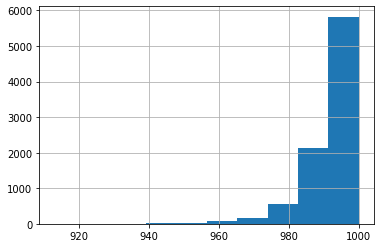

In [36]:
train_set_by_customer['num_negative_samples'].hist()

In [38]:
# (train_set_by_customer['num_negative_samples'] == 1000).mean()

Drop customers with 1000 negative examples, which means they had no positive examples in this set

In [39]:
# train_set_by_customer = train_set_by_customer.copy()[train_set_by_customer['num_negative_samples'] != 1000]

In [40]:
train_set_by_customer.head()

,customer_id,article_id,negative_samples,num_negative_samples
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0723529001, 0351484002, 0351484002, 0851400006]","[0554450027, 0685814001, 0857812006, 081803100...",998
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[0714029002, 0591334019, 0685813001, 075147100...","[0554450027, 0685814001, 0857812006, 081803100...",989
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[0570002001, 0770816001, 0501620042, 082217100...","[0554450027, 0685814001, 0857812006, 081803100...",999
3,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[0201219001, 0322017003, 0156231001, 075475100...","[0554450027, 0685814001, 0857812006, 081803100...",990
4,004d932f7a27ac3167c77db81d9cfd89392729e7f7e0d4...,"[0679854005, 0679854005, 0679854005, 057371601...","[0554450027, 0685814001, 0857812006, 081803100...",988


In [41]:
negative_samples_df = train_set_by_customer[['customer_id', 'negative_samples']].explode('negative_samples')
negative_samples_df['purchased'] = 0
negative_samples_df.rename(columns={'negative_samples': 'article_id'}, inplace=True)
print(negative_samples_df.shape)
negative_samples_df.head()

(8710061, 3)


,customer_id,article_id,purchased
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0554450027,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0685814001,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0857812006,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0818031003,0
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0832359001,0


In [42]:
positive_samples = train_set.copy()
positive_samples['purchased'] = 1
print(positive_samples.shape)
positive_samples.head()

(194584, 4)


,customer_id,article_id,customer_id_idx,purchased
17,02d796ea767fa2e94fc6228fe70d8af1a570da973c32f7...,0575347003,3631,1
43,09bca14258b7e9b9ee968adffe54d45c1e370e8ed79a22...,0579541001,1120,1
55,183c939bc508ee9c530be249a4e940aace700cdc774e2c...,0615141002,8343,1
72,1b9496dbe47dd45ffff1630aa2b532d1a5c924c6104d66...,0562245046,2259,1
77,1b9496dbe47dd45ffff1630aa2b532d1a5c924c6104d66...,0562245001,2259,1


In [43]:
train_set = pd.concat([
    positive_samples,
    negative_samples_df
])

train_set = train_set.sample(frac=1, random_state=3)  # shuffle
print(train_set.shape)
train_set.head()

(8904645, 4)


,customer_id,article_id,customer_id_idx,purchased
5015,9165937ca0e3520ebe0533ffd6bb41eb5f3d2d61d04338...,0554450001,NaN,0
6805,c57b05d88861137cb87f02719a38968ec5a4b7e6c970bf...,0685814002,NaN,0
4477,804895ebec804fab7bc7d8b96a2a74e00e0af79759b119...,0770315007,NaN,0
6345,b6f4078b1474d782c8316694af3afdd64041209f6114ac...,0746775001,NaN,0
7911,e60e66e755cda27055e3e22328012d6c0ab7b28b18f7ec...,0733803001,NaN,0


In [44]:
train_set['purchased'].mean()

0.021851966024473743

In [45]:
# Check at least 1 positive label per customer
train_set.groupby('customer_id')['purchased'].sum().min() >= 1

True

Dev set prep

In [46]:
dev_set.head()

,customer_id,article_id,customer_id_idx
580395,00639e775b90554156986100685c4d408723c77e411e37...,0891591007,1072
580396,00639e775b90554156986100685c4d408723c77e411e37...,0891591001,1072
580397,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0909924004,8244
580398,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0921266005,8244
580399,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0857163001,8244


In [48]:
# # For purposes of dev set only include transactions in top-1000
# dev_set['article_id'].isin(top_1000).mean()

In [49]:
# positive_samples_dev = dev_set.copy()[dev_set['article_id'].isin(top_1000)]
positive_samples_dev = dev_set.copy()
positive_samples_dev['purchased'] = 1
print(positive_samples_dev.shape)
positive_samples_dev.head()

(8363, 4)


,customer_id,article_id,customer_id_idx,purchased
580395,00639e775b90554156986100685c4d408723c77e411e37...,0891591007,1072,1
580396,00639e775b90554156986100685c4d408723c77e411e37...,0891591001,1072,1
580397,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0909924004,8244,1
580398,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0921266005,8244,1
580399,016f3b7c2b7652870b4b2dbdcb1805a7c8c262036f5511...,0857163001,8244,1


In [50]:
positive_samples_dev_by_customer = positive_samples_dev.groupby('customer_id')['article_id'].apply(lambda x: list(x)).reset_index()
print(positive_samples_dev_by_customer.shape)
positive_samples_dev_by_customer.head()

(1998, 2)


,customer_id,article_id
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,[0903924001]
1,0054c50274d19af58d53ef3ce0c004bea446c80bd51cf2...,"[0766346011, 0568601043, 0763037001]"
2,00639e775b90554156986100685c4d408723c77e411e37...,"[0891591007, 0891591001, 0891591001]"
3,00798bd464457d23d6af401715fe32d5c676ad9ee4010d...,[0916775002]
4,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,"[0867969003, 0867969003, 0448509014, 088290001..."


In [51]:
positive_samples_dev_by_customer['negative_samples'] = positive_samples_dev_by_customer.apply(lambda x: list(set(top_1000) - set(x['article_id'])), axis=1)

In [52]:
negative_samples_df = positive_samples_dev_by_customer[['customer_id', 'negative_samples']].explode('negative_samples')
negative_samples_df['purchased'] = 0
negative_samples_df.rename(columns={'negative_samples': 'article_id'}, inplace=True)
print(negative_samples_df.shape)
negative_samples_df.head()

(1996939, 3)


,customer_id,article_id,purchased
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0554450027,0
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0685814001,0
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0857812006,0
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0818031003,0
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,0832359001,0


In [53]:
dev_set = pd.concat([
    positive_samples_dev,
    negative_samples_df
])

dev_set = dev_set.sample(frac=1, random_state=3)  # shuffle
print(dev_set.shape)
dev_set.head()

(2005302, 4)


,customer_id,article_id,customer_id_idx,purchased
1922,f7cff47ca5eed528a9990e21e619878b002d7ce393f471...,0610776001,NaN,0
1247,9d4f9874a43da353c42bfdf70368ac6ef7c080613a0ab0...,0841434003,NaN,0
73,0b50b5aeb1d21ccf35ab72b056b041950806e6474d2be6...,0843793004,NaN,0
1502,c037b35b7422f7c90b50c85f76fe0c35af5b633f90b63d...,0780297001,NaN,0
135,136b571bf08e948b9fc5ef62c1e300a9a2f00e2bbddd9f...,0842605001,NaN,0


In [54]:
dev_set['purchased'].mean()

0.004170444152551586

`article_id` to indices

In [59]:
articles_df = pd.read_csv(
    'data/articles.csv', 
    dtype={'article_id': str},
    usecols=['article_id', 'garment_group_name', 'detail_desc']
)
print(articles_df.shape)
articles_df.head()

(105542, 3)


,article_id,garment_group_name,detail_desc
0,0108775015,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [60]:
# articles_df = articles_df.copy()[articles_df['article_id'].isin(top_1000)]

In [61]:
articles_df.reset_index(drop=True, inplace=True)

In [62]:
print(articles_df.shape)
articles_df.head()

(105542, 3)


,article_id,garment_group_name,detail_desc
0,0108775015,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [63]:
articles_df['article_id_idx'] = articles_df.index

In [64]:
articles_df.isnull().sum()

article_id              0
garment_group_name      0
detail_desc           416
article_id_idx          0
dtype: int64

In [65]:
articles_df['detail_desc'] = np.where(
    articles_df['detail_desc'].isnull(), 
    articles_df['garment_group_name'],
    articles_df['detail_desc']
)

In [66]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [67]:
article_descriptions = articles_df['detail_desc'].to_list()
article_descriptions[:5]

['Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.']

In [68]:
embeddings = model.encode(article_descriptions)

In [69]:
embeddings = torch.tensor(embeddings)

In [70]:
embeddings.shape

torch.Size([105542, 384])

In [71]:
article_id_to_idx = dict(
    zip(
        articles_df['article_id'], 
        articles_df['article_id_idx']
    )
)

In [72]:
train_set['article_id_idx'] = train_set['article_id'].map(article_id_to_idx)
dev_set['article_id_idx'] = dev_set['article_id'].map(article_id_to_idx)

In [73]:
train_set.head()

,customer_id,article_id,customer_id_idx,purchased,article_id_idx
5015,9165937ca0e3520ebe0533ffd6bb41eb5f3d2d61d04338...,0554450001,NaN,0,12585
6805,c57b05d88861137cb87f02719a38968ec5a4b7e6c970bf...,0685814002,NaN,0,46383
4477,804895ebec804fab7bc7d8b96a2a74e00e0af79759b119...,0770315007,NaN,0,73050
6345,b6f4078b1474d782c8316694af3afdd64041209f6114ac...,0746775001,NaN,0,66108
7911,e60e66e755cda27055e3e22328012d6c0ab7b28b18f7ec...,0733803001,NaN,0,61632


In [74]:
dev_set.head()

,customer_id,article_id,customer_id_idx,purchased,article_id_idx
1922,f7cff47ca5eed528a9990e21e619878b002d7ce393f471...,0610776001,NaN,0,24836
1247,9d4f9874a43da353c42bfdf70368ac6ef7c080613a0ab0...,0841434003,NaN,0,90096
73,0b50b5aeb1d21ccf35ab72b056b041950806e6474d2be6...,0843793004,NaN,0,90582
1502,c037b35b7422f7c90b50c85f76fe0c35af5b633f90b63d...,0780297001,NaN,0,75215
135,136b571bf08e948b9fc5ef62c1e300a9a2f00e2bbddd9f...,0842605001,NaN,0,90340


In [75]:
train_set['customer_id_idx'] = train_set['customer_id'].map(customer_id_to_idx)
dev_set['customer_id_idx'] = dev_set['customer_id'].map(customer_id_to_idx)

In [76]:
train_set['customer_id_idx'].isnull().sum() + dev_set['customer_id_idx'].isnull().sum()

0

In [77]:
train_set['article_id_idx'].isnull().sum() + dev_set['article_id_idx'].isnull().sum()

0

### Merge features

In [78]:
train_set.head()

,customer_id,article_id,customer_id_idx,purchased,article_id_idx
5015,9165937ca0e3520ebe0533ffd6bb41eb5f3d2d61d04338...,0554450001,8789,0,12585
6805,c57b05d88861137cb87f02719a38968ec5a4b7e6c970bf...,0685814002,1892,0,46383
4477,804895ebec804fab7bc7d8b96a2a74e00e0af79759b119...,0770315007,6818,0,73050
6345,b6f4078b1474d782c8316694af3afdd64041209f6114ac...,0746775001,5935,0,66108
7911,e60e66e755cda27055e3e22328012d6c0ab7b28b18f7ec...,0733803001,6136,0,61632


In [79]:
train_set = (
    train_set[['purchased', 'customer_id_idx', 'article_id_idx']]
    .merge(customers, on='customer_id_idx', how='left')
    # .merge(articles_df, on='article_id_idx', how='left')
)
print(train_set.shape)
train_set.head()

(8904645, 10)


,purchased,customer_id_idx,article_id_idx,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,0,8789,12585,9165937ca0e3520ebe0533ffd6bb41eb5f3d2d61d04338...,0.0,0.0,0,0,30.0,293202
1,0,1892,46383,c57b05d88861137cb87f02719a38968ec5a4b7e6c970bf...,1.0,1.0,0,1,21.0,83211
2,0,6818,73050,804895ebec804fab7bc7d8b96a2a74e00e0af79759b119...,0.0,0.0,0,0,23.0,17012
3,0,5935,66108,b6f4078b1474d782c8316694af3afdd64041209f6114ac...,1.0,1.0,0,1,49.0,319383
4,0,6136,61632,e60e66e755cda27055e3e22328012d6c0ab7b28b18f7ec...,0.0,0.0,0,0,20.0,28596


In [80]:
dev_set = (
    dev_set[['purchased', 'customer_id_idx', 'article_id_idx']]
    .merge(customers, on='customer_id_idx', how='left')
    # .merge(articles_df, on='article_id_idx', how='left')
)
print(dev_set.shape)
dev_set.head()

(2005302, 10)


,purchased,customer_id_idx,article_id_idx,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,0,4933,24836,f7cff47ca5eed528a9990e21e619878b002d7ce393f471...,0.0,0.0,0,0,24.0,272622
1,0,660,90096,9d4f9874a43da353c42bfdf70368ac6ef7c080613a0ab0...,0.0,0.0,0,0,43.0,233912
2,0,5034,90582,0b50b5aeb1d21ccf35ab72b056b041950806e6474d2be6...,1.0,1.0,0,1,20.0,49473
3,0,7060,75215,c037b35b7422f7c90b50c85f76fe0c35af5b633f90b63d...,1.0,1.0,0,1,53.0,17595
4,0,80,90340,136b571bf08e948b9fc5ef62c1e300a9a2f00e2bbddd9f...,0.0,0.0,0,0,20.0,32754


### Impute `NULL`s

In [81]:
train_set.isnull().sum()[train_set.isnull().sum() > 0]

age    32229
dtype: int64

In [82]:
dev_set.isnull().sum()[dev_set.isnull().sum() > 0]

age    7020
dtype: int64

In [83]:
from sklearn.impute import SimpleImputer

In [84]:
age_imputer = SimpleImputer()

In [85]:
age_imputer.fit(train_set['age'].values.reshape(-1, 1))

SimpleImputer()

In [86]:
train_set['age'] = age_imputer.transform(train_set['age'].values.reshape(-1, 1))

In [87]:
dev_set['age'] = age_imputer.transform(dev_set['age'].values.reshape(-1, 1))

In [88]:
train_set.head()

,purchased,customer_id_idx,article_id_idx,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,0,8789,12585,9165937ca0e3520ebe0533ffd6bb41eb5f3d2d61d04338...,0.0,0.0,0,0,30.0,293202
1,0,1892,46383,c57b05d88861137cb87f02719a38968ec5a4b7e6c970bf...,1.0,1.0,0,1,21.0,83211
2,0,6818,73050,804895ebec804fab7bc7d8b96a2a74e00e0af79759b119...,0.0,0.0,0,0,23.0,17012
3,0,5935,66108,b6f4078b1474d782c8316694af3afdd64041209f6114ac...,1.0,1.0,0,1,49.0,319383
4,0,6136,61632,e60e66e755cda27055e3e22328012d6c0ab7b28b18f7ec...,0.0,0.0,0,0,20.0,28596


### Train model

In [89]:
NUMERIC_FEATURES = [
    'FN', 
    'Active', 
    'age'
]

In [90]:
# train_set[[
#     'customer_id_idx',
#     'article_id_idx',
#     'product_code',
#     'product_type_no',
#     'graphical_appearance_no',
#     'perceived_colour_value_id',
#     'perceived_colour_master_id',
#     'department_no',
#     'index_code',
#     'index_group_no',
#     'section_no',
#     'garment_group_no',
#     'club_member_status',
#     'fashion_news_frequency',
#     'postal_code',
#     'purchased'] +
#     NUMERIC_FEATURES
# ]

In [91]:
train_set.head()

,purchased,customer_id_idx,article_id_idx,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,0,8789,12585,9165937ca0e3520ebe0533ffd6bb41eb5f3d2d61d04338...,0.0,0.0,0,0,30.0,293202
1,0,1892,46383,c57b05d88861137cb87f02719a38968ec5a4b7e6c970bf...,1.0,1.0,0,1,21.0,83211
2,0,6818,73050,804895ebec804fab7bc7d8b96a2a74e00e0af79759b119...,0.0,0.0,0,0,23.0,17012
3,0,5935,66108,b6f4078b1474d782c8316694af3afdd64041209f6114ac...,1.0,1.0,0,1,49.0,319383
4,0,6136,61632,e60e66e755cda27055e3e22328012d6c0ab7b28b18f7ec...,0.0,0.0,0,0,20.0,28596


In [92]:
class PurchasesDatasetWithArticleFeatures(Dataset):

    def __init__(self, df):
        self.customer_id_idx = df['customer_id_idx'].values
        self.article_id_idx = df['article_id_idx'].values
        # self.product_code = df['product_code'].values
        # self.product_type_no = df['product_type_no'].values
        # self.product_group_no = df['product_group_no'].values
        # self.graphical_appearance_no = df['graphical_appearance_no'].values
        # self.colour_group_code = df['colour_group_code'].values
        # self.perceived_colour_value_id = df['perceived_colour_value_id'].values
        # self.perceived_colour_master_id = df['perceived_colour_master_id'].values
        # self.department_no = df['department_no'].values
        # self.index_code = df['index_code'].values
        # self.index_group_no = df['index_group_no'].values
        # self.section_no = df['section_no'].values
        # self.garment_group_no = df['garment_group_no'].values
        
        # self.club_member_status = df['club_member_status'].values
        # self.fashion_news_frequency = df['fashion_news_frequency'].values
        # self.postal_code = df['postal_code'].values
        self.numeric_features = df[NUMERIC_FEATURES].values
        
        self.purchased = df['purchased'].values

    def __len__(self):
        return self.customer_id_idx.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return (
            self.customer_id_idx[idx],
            self.article_id_idx[idx],
            # self.product_code[idx],
            # self.product_type_no[idx],
            # self.product_group_no[idx],
            # self.graphical_appearance_no[idx],
            # self.colour_group_code[idx],
            # self.perceived_colour_value_id[idx],
            # self.perceived_colour_master_id[idx],
            # self.department_no[idx],
            # self.index_code[idx],
            # self.index_group_no[idx],
            # self.section_no[idx],
            # self.garment_group_no[idx],
            # self.club_member_status[idx],
            # self.fashion_news_frequency[idx],
            # self.postal_code[idx],
            self.numeric_features[idx],
            self.purchased[idx]
        )

In [93]:
train_dataset = PurchasesDatasetWithArticleFeatures(train_set)
dev_dataset = PurchasesDatasetWithArticleFeatures(dev_set)

In [94]:
BATCH_SIZE = 2048

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)  

In [95]:
# # Selecting a subset of data
# subset = torch.utils.data.Subset(train_dataset, [1])

# train_loader = DataLoader(subset, batch_size=BATCH_SIZE)  

In [225]:
class FashionRecV2(nn.Module):

    def __init__(self, embedding_dim):
        super(FashionRecV2, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customer_id_to_idx), embedding_dim=embedding_dim)        
        # self.item_embeddings = nn.Embedding(num_embeddings=len(article_id_to_idx), embedding_dim=embedding_dim)
        self.item_embeddings = nn.Embedding.from_pretrained(embeddings, freeze=True)
        # self.product_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_code']), embedding_dim=embedding_dim)
        # self.product_type_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_type_no']), embedding_dim=embedding_dim)
        # self.product_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_group_no']), embedding_dim=embedding_dim)
        # self.graphical_appearance_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['graphical_appearance_no']), embedding_dim=embedding_dim)
        # self.colour_group_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['colour_group_code']), embedding_dim=embedding_dim)
        # self.perceived_colour_value_id_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['perceived_colour_value_id']), embedding_dim=embedding_dim)
        # self.perceived_colour_master_id_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['perceived_colour_master_id']), embedding_dim=embedding_dim)
        # self.department_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['department_no']), embedding_dim=embedding_dim)
        # self.index_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['index_code']), embedding_dim=embedding_dim)
        # self.index_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['index_group_no']), embedding_dim=embedding_dim)
        # self.section_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['section_no']), embedding_dim=embedding_dim)
        # self.garment_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['garment_group_no']), embedding_dim=embedding_dim)
        
        # self.club_member_status_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['club_member_status']), embedding_dim=embedding_dim)
        # self.fashion_news_frequency_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['fashion_news_frequency']), embedding_dim=embedding_dim)
        # self.postal_code_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['postal_code']), embedding_dim=embedding_dim)

        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.item_embeddings.weight)        
        # torch.nn.init.xavier_uniform_(self.product_code_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.product_type_no_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.product_group_no_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.graphical_appearance_no_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.colour_group_code_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.perceived_colour_value_id_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.perceived_colour_master_id_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.department_no_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.index_code_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.index_group_no_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.section_no_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.garment_group_no_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.club_member_status_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.fashion_news_frequency_embeddings.weight)
        # torch.nn.init.xavier_uniform_(self.postal_code_embeddings.weight)
        
        # FC layers
        # self.fc_1 = nn.Linear(in_features=embedding_dim*17+len(NUMERIC_FEATURES), out_features=128)            
        self.fc_1 = nn.Linear(in_features=embedding_dim + 384 +len(NUMERIC_FEATURES), out_features=256)            
        self.fc_2 = nn.Linear(in_features=256, out_features=128)
        # self.fc_3 = nn.Linear(in_features=500, out_features=250)        
        self.fc_3 = nn.Linear(in_features=128, out_features=1)
        
        # Activation functions
        self.relu = nn.ReLU()        
        self.sigmoid = nn.Sigmoid()
        
        # Dropout
        self.dropout = nn.Dropout(0.2)
        
    def forward(
        self, 
        user_id, 
        item_id,
        # product_code, 
        # product_type_no, 
        # product_group_no, 
        # graphical_appearance_no, 
        # colour_group_code, 
        # perceived_colour_value_id, 
        # perceived_colour_master_id, 
        # department_no, 
        # index_code, 
        # index_group_no, 
        # section_no, 
        # garment_group_no,
        # club_member_status,
        # fashion_news_frequency,
        # postal_code,
        numeric_features,
    ):

        user_emb = self.user_embeddings(user_id)
        item_emb = self.item_embeddings(item_id)
        # product_code_emb = self.product_code_embeddings(product_code)
        # product_type_no_emb = self.product_type_no_embeddings(product_type_no)
        # product_group_no_emb = self.product_group_no_embeddings(product_group_no)
        # graphical_appearance_no_emb = self.graphical_appearance_no_embeddings(graphical_appearance_no)
        # colour_group_code_emb = self.colour_group_code_embeddings(colour_group_code)
        # perceived_colour_value_id_emb = self.perceived_colour_value_id_embeddings(perceived_colour_value_id)
        # perceived_colour_master_id_emb = self.perceived_colour_master_id_embeddings(perceived_colour_master_id)
        # department_no_emb = self.department_no_embeddings(department_no)
        # index_code_emb = self.index_code_embeddings(index_code)
        # index_group_no_emb = self.index_group_no_embeddings(index_group_no)
        # section_no_emb = self.section_no_embeddings(section_no)
        # garment_group_no_emb = self.garment_group_no_embeddings(garment_group_no)
        
        # club_member_status_emb = self.club_member_status_embeddings(club_member_status)
        # fashion_news_frequency_emb = self.fashion_news_frequency_embeddings(fashion_news_frequency)
        # postal_code_emb = self.postal_code_embeddings(postal_code)
              
        concatenated_emb = torch.concat(
            [
                user_emb, 
                item_emb,
                # product_code_emb,
                # product_type_no_emb,
                # product_group_no_emb,
                # graphical_appearance_no_emb,
                # colour_group_code_emb,
                # perceived_colour_value_id_emb,
                # perceived_colour_master_id_emb,
                # department_no_emb,
                # index_code_emb,
                # index_group_no_emb,
                # section_no_emb,
                # garment_group_no_emb,
                # club_member_status_emb,
                # fashion_news_frequency_emb,
                # postal_code_emb,
                numeric_features
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_emb)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_3(x)
        x = self.sigmoid(x)

        return x

In [253]:
fashion_rec_v2 = FashionRecV2(embedding_dim=128)

In [254]:
fashion_rec_v2.to(device)

FashionRecV2(
  (user_embeddings): Embedding(9208, 128)
  (item_embeddings): Embedding(105542, 384)
  (fc_1): Linear(in_features=515, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=128, bias=True)
  (fc_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [255]:
# fashion_rec_v2(torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), )

In [256]:
# optimizer = torch.optim.Adam(params=fashion_rec_v2.parameters(), lr=0.001)
optimizer = torch.optim.Adam(params=fashion_rec_v2.parameters(), lr=0.0003)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

Switched to BCELoss instead of weighted MSE. Had more success with this.

In [257]:
criterion = nn.BCELoss()

In [258]:
# MAX_EPOCHS = 5
# training_losses = []
# dev_losses = []

# for epoch in range(MAX_EPOCHS):
    
#     for data in tqdm(train_loader):
        
#         user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data    
        
#         user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
#             user_id.to(device), 
#             item_id.to(device), 
#             product_code.to(device), 
#             product_type_no.to(device), 
#             product_group_no.to(device), 
#             graphical_appearance_no.to(device), 
#             colour_group_code.to(device), 
#             perceived_colour_value_id.to(device), 
#             perceived_colour_master_id.to(device), 
#             department_no.to(device), 
#             index_code.to(device), 
#             index_group_no.to(device), 
#             section_no.to(device), 
#             garment_group_no.to(device), 
#             club_member_status.to(device), 
#             fashion_news_frequency.to(device), 
#             postal_code.to(device), 
#             numeric_features.to(device),
#             label.to(device)
#         )    

#         optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

#         pred = fashion_rec_v2(
#             user_id, 
#             item_id, 
#             product_code, 
#             product_type_no, 
#             product_group_no, 
#             graphical_appearance_no, 
#             colour_group_code, 
#             perceived_colour_value_id, 
#             perceived_colour_master_id, 
#             department_no, 
#             index_code, 
#             index_group_no, 
#             section_no, 
#             garment_group_no,
#             club_member_status,
#             fashion_news_frequency,
#             postal_code,
#             numeric_features.float()
#         )

#         loss = criterion(pred.flatten(), label.float())

#         loss.backward()  
        
#         optimizer.step()
        
#     # Compute training loss
    
#     total_train_loss = 0

#     fashion_rec_v2.eval()

#     with torch.no_grad():
#         for data in tqdm(DataLoader(train_dataset, batch_size=BATCH_SIZE*4)):
            
#             user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data

#             user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
#                 user_id.to(device), 
#                 item_id.to(device), 
#                 product_code.to(device), 
#                 product_type_no.to(device), 
#                 product_group_no.to(device), 
#                 graphical_appearance_no.to(device), 
#                 colour_group_code.to(device), 
#                 perceived_colour_value_id.to(device), 
#                 perceived_colour_master_id.to(device), 
#                 department_no.to(device), 
#                 index_code.to(device), 
#                 index_group_no.to(device), 
#                 section_no.to(device), 
#                 garment_group_no.to(device), 
#                 club_member_status.to(device), 
#                 fashion_news_frequency.to(device), 
#                 postal_code.to(device), 
#                 numeric_features.to(device),
#                 label.to(device)
#             )

#             pred = fashion_rec_v2(
#                 user_id, 
#                 item_id, 
#                 product_code, 
#                 product_type_no, 
#                 product_group_no, 
#                 graphical_appearance_no, 
#                 colour_group_code, 
#                 perceived_colour_value_id, 
#                 perceived_colour_master_id, 
#                 department_no, 
#                 index_code, 
#                 index_group_no, 
#                 section_no, 
#                 garment_group_no,
#                 club_member_status,
#                 fashion_news_frequency,
#                 postal_code,
#                 numeric_features.float()
#             )

#             loss = nn.BCELoss(reduction='sum')(pred.flatten(), label.float())

#             total_train_loss += loss.item()

#         mean_train_loss = total_train_loss / len(train_dataset)

#         print(f"Training loss: {mean_train_loss}")
#         training_losses.append(mean_train_loss)
    
#     # Compute dev loss
    
#     total_dev_loss = 0

#     with torch.no_grad():
#         for data in tqdm(DataLoader(dev_dataset, batch_size=BATCH_SIZE*4)):
            
#             user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data                    
        
#             user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
#                 user_id.to(device), 
#                 item_id.to(device), 
#                 product_code.to(device), 
#                 product_type_no.to(device), 
#                 product_group_no.to(device), 
#                 graphical_appearance_no.to(device), 
#                 colour_group_code.to(device), 
#                 perceived_colour_value_id.to(device), 
#                 perceived_colour_master_id.to(device), 
#                 department_no.to(device), 
#                 index_code.to(device), 
#                 index_group_no.to(device), 
#                 section_no.to(device), 
#                 garment_group_no.to(device), 
#                 club_member_status.to(device), 
#                 fashion_news_frequency.to(device), 
#                 postal_code.to(device), 
#                 numeric_features.to(device),
#                 label.to(device)
#             )    

#             optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

#             pred = fashion_rec_v2(
#                 user_id, 
#                 item_id, 
#                 product_code, 
#                 product_type_no, 
#                 product_group_no, 
#                 graphical_appearance_no, 
#                 colour_group_code, 
#                 perceived_colour_value_id, 
#                 perceived_colour_master_id, 
#                 department_no, 
#                 index_code, 
#                 index_group_no, 
#                 section_no, 
#                 garment_group_no,
#                 club_member_status,
#                 fashion_news_frequency,
#                 postal_code,
#                 numeric_features.float()
#             )

#             loss = nn.BCELoss(reduction='sum')(pred.flatten(), label.float())

#             total_dev_loss += loss.item()

#         mean_dev_loss = total_dev_loss / len(dev_dataset)

#         print(f"Dev loss: {mean_dev_loss}")
#         dev_losses.append(mean_dev_loss)
    
#     fashion_rec_v2.train()

In [287]:
MAX_EPOCHS = 30
# training_losses = []
# dev_losses = []

for epoch in range(MAX_EPOCHS):
    
    for data in tqdm(train_loader):
        
        user_id, item_id, numeric_features, label = data    
        
        user_id, item_id, numeric_features, label = (
            user_id.to(device), 
            item_id.to(device), 
            numeric_features.to(device),
            label.to(device)
        )    

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        pred = fashion_rec_v2(
            user_id, 
            item_id, 
            numeric_features.float()
        )

        loss = criterion(pred.flatten(), label.float())

        loss.backward()  
        
        optimizer.step()

    scheduler.step()
        
    # Compute training loss
    
    total_train_loss = 0

    fashion_rec_v2.eval()

    with torch.no_grad():
        for data in tqdm(DataLoader(train_dataset, batch_size=BATCH_SIZE*4)):
            
            user_id, item_id, numeric_features, label = data

            user_id, item_id, numeric_features, label = (
                user_id.to(device), 
                item_id.to(device), 
                numeric_features.to(device),
                label.to(device)
            )

            pred = fashion_rec_v2(
                user_id, 
                item_id, 
                numeric_features.float()
            )

            loss = nn.BCELoss(reduction='sum')(pred.flatten(), label.float())

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss / len(train_dataset)

        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)
    
    # Compute dev loss
    
    total_dev_loss = 0

    with torch.no_grad():
        for data in tqdm(DataLoader(dev_dataset, batch_size=BATCH_SIZE*4)):
            
            user_id, item_id, numeric_features, label = data                    
        
            user_id, item_id, numeric_features, label = (
                user_id.to(device), 
                item_id.to(device), 
                numeric_features.to(device),
                label.to(device)
            )    

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            pred = fashion_rec_v2(
                user_id, 
                item_id, 
                numeric_features.float()
            )

            loss = nn.BCELoss(reduction='sum')(pred.flatten(), label.float())

            total_dev_loss += loss.item()

        mean_dev_loss = total_dev_loss / len(dev_dataset)

        print(f"Dev loss: {mean_dev_loss}")
        dev_losses.append(mean_dev_loss)
    
    fashion_rec_v2.train()

100%|██████████| 1087/1087 [01:03<00:00, 17.08it/s]


Training loss: 0.05674469082749658


100%|██████████| 245/245 [00:14<00:00, 17.09it/s]


Dev loss: 0.034017162520286165


100%|██████████| 1087/1087 [01:03<00:00, 17.17it/s]


Training loss: 0.058183734427078464


100%|██████████| 245/245 [00:14<00:00, 17.14it/s]


Dev loss: 0.03027127766024447


100%|██████████| 1087/1087 [01:03<00:00, 17.09it/s]


Training loss: 0.05820635467673117


100%|██████████| 245/245 [00:14<00:00, 16.94it/s]


Dev loss: 0.029730188124675042


100%|██████████| 1087/1087 [01:03<00:00, 17.07it/s]


Training loss: 0.057412660109527766


100%|██████████| 245/245 [00:14<00:00, 17.35it/s]


Dev loss: 0.03401460595088884


100%|██████████| 1087/1087 [01:03<00:00, 17.01it/s]


Training loss: 0.05759683340708785


100%|██████████| 245/245 [00:14<00:00, 17.07it/s]


Dev loss: 0.030972075165272506


100%|██████████| 1087/1087 [01:04<00:00, 16.81it/s]


Training loss: 0.057532629416348506


100%|██████████| 245/245 [00:14<00:00, 16.93it/s]


Dev loss: 0.030921305169738674


100%|██████████| 1087/1087 [01:03<00:00, 17.07it/s]


Training loss: 0.057444858178268984


100%|██████████| 245/245 [00:14<00:00, 16.99it/s]


Dev loss: 0.030333176227360332


100%|██████████| 1087/1087 [01:03<00:00, 17.09it/s]


Training loss: 0.05734024220365861


100%|██████████| 245/245 [00:14<00:00, 17.04it/s]


Dev loss: 0.030636030343520266


100%|██████████| 1087/1087 [01:03<00:00, 17.05it/s]


Training loss: 0.05688338052410186


100%|██████████| 245/245 [00:14<00:00, 16.99it/s]


Dev loss: 0.032084568404800964


100%|██████████| 1087/1087 [01:03<00:00, 17.06it/s]


Training loss: 0.05673002521516356


100%|██████████| 245/245 [00:14<00:00, 16.96it/s]


Dev loss: 0.03265326022752258


100%|██████████| 1087/1087 [01:03<00:00, 17.08it/s]


Training loss: 0.05683489428842773


100%|██████████| 245/245 [00:14<00:00, 16.85it/s]


Dev loss: 0.03154926185549053


100%|██████████| 1087/1087 [01:03<00:00, 17.09it/s]


Training loss: 0.05663732547104256


100%|██████████| 245/245 [00:14<00:00, 17.00it/s]


Dev loss: 0.031257103848362056


100%|██████████| 1087/1087 [01:03<00:00, 17.03it/s]


Training loss: 0.05645864154334422


100%|██████████| 245/245 [00:14<00:00, 16.97it/s]


Dev loss: 0.03257163991017381


100%|██████████| 1087/1087 [01:03<00:00, 17.04it/s]


Training loss: 0.05648611547401358


100%|██████████| 245/245 [00:14<00:00, 16.84it/s]


Dev loss: 0.03151272147124155


100%|██████████| 1087/1087 [01:03<00:00, 17.02it/s]


Training loss: 0.05618313012656531


100%|██████████| 245/245 [00:14<00:00, 17.03it/s]


Dev loss: 0.03372732591953419


100%|██████████| 1087/1087 [01:03<00:00, 16.99it/s]


Training loss: 0.05620785951795778


100%|██████████| 245/245 [00:14<00:00, 17.08it/s]


Dev loss: 0.0328010307726585


100%|██████████| 1087/1087 [01:03<00:00, 16.99it/s]


Training loss: 0.05653191876662624


100%|██████████| 245/245 [00:14<00:00, 16.81it/s]


Dev loss: 0.030999723503439162


100%|██████████| 1087/1087 [01:04<00:00, 16.88it/s]


Training loss: 0.05627298404533862


100%|██████████| 245/245 [00:14<00:00, 16.85it/s]


Dev loss: 0.03150145649673731


100%|██████████| 1087/1087 [01:03<00:00, 17.10it/s]


Training loss: 0.0561326694431067


100%|██████████| 245/245 [00:14<00:00, 17.27it/s]


Dev loss: 0.03295956864914831


100%|██████████| 1087/1087 [01:05<00:00, 16.62it/s]


Training loss: 0.056020185613537235


100%|██████████| 245/245 [00:14<00:00, 17.34it/s]


Dev loss: 0.032959475223114675


100%|██████████| 1087/1087 [01:02<00:00, 17.34it/s]


Training loss: 0.055964571650800383


100%|██████████| 245/245 [00:14<00:00, 17.03it/s]


Dev loss: 0.033050081370212855


100%|██████████| 1087/1087 [01:02<00:00, 17.37it/s]


Training loss: 0.056099984561033524


100%|██████████| 245/245 [00:13<00:00, 17.51it/s]


Dev loss: 0.031573953866147524


100%|██████████| 1087/1087 [01:02<00:00, 17.36it/s]


Training loss: 0.0560390962788395


100%|██████████| 245/245 [00:14<00:00, 17.43it/s]


Dev loss: 0.03229538927179535


100%|██████████| 1087/1087 [01:01<00:00, 17.55it/s]


Training loss: 0.05598719586566876


100%|██████████| 245/245 [00:14<00:00, 17.40it/s]


Dev loss: 0.032340038073958514


100%|██████████| 1087/1087 [01:02<00:00, 17.39it/s]


Training loss: 0.05586170153288962


100%|██████████| 245/245 [00:14<00:00, 17.47it/s]


Dev loss: 0.0337048641035038


100%|██████████| 1087/1087 [01:02<00:00, 17.31it/s]


Training loss: 0.05597697588041656


100%|██████████| 245/245 [00:14<00:00, 17.22it/s]


Dev loss: 0.032549779991251006


100%|██████████| 1087/1087 [01:02<00:00, 17.51it/s]


Training loss: 0.05589874487241477


100%|██████████| 245/245 [00:14<00:00, 17.15it/s]


Dev loss: 0.032357455538565505


100%|██████████| 1087/1087 [01:02<00:00, 17.36it/s]


Training loss: 0.05602609234548154


100%|██████████| 245/245 [00:14<00:00, 17.33it/s]


Dev loss: 0.0318123060110299


100%|██████████| 1087/1087 [01:02<00:00, 17.35it/s]


Training loss: 0.055880026734269554


100%|██████████| 245/245 [00:14<00:00, 17.26it/s]


Dev loss: 0.03235434362528375


100%|██████████| 1087/1087 [01:02<00:00, 17.42it/s]


Training loss: 0.055938248993254974


100%|██████████| 245/245 [00:14<00:00, 17.41it/s]

Dev loss: 0.032122836318439346


Training loss: 0.0576722645855583
100%|██████████| 245/245 [00:13<00:00, 17.61it/s]Dev loss: 0.030502201788668592

In [288]:
train_set['purchased'].mean(), dev_set['purchased'].mean()

(0.021851966024473743, 0.004170444152551586)

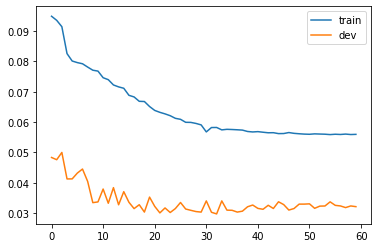

In [289]:
plt.plot(training_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()
plt.show()

### Test set evaluation

In [290]:
test_set.head()

,t_dat,customer_id,article_id,article_id_idx
0,2020-09-15,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007,78503
1,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010,74893
2,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010,74893
3,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0610776105,24872
4,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0929745001,104987


In [291]:
test_set['article_id_idx'] = test_set['article_id'].map(article_id_to_idx)

test_set['article_id_idx'].fillna(999999, inplace=True)

test_set_by_customer = test_set.groupby('customer_id').apply(lambda x: list(x['article_id_idx'])).reset_index().rename(columns={0: 'article_id_idx'})
test_set_by_customer.head()

,customer_id,article_id_idx
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[78503]
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[74893, 74893, 24872, 104987, 9801, 9801, 6912..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[92815, 86041]"
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[104211, 17044, 17044, 16024, 29250, 98445, 66..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[87467, 99966, 42626, 79834, 97540, 103280, 79..."


In [292]:
test_set.shape

(32995, 4)

In [293]:
train_set.head()

,purchased,customer_id_idx,article_id_idx,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,0,8789,12585,9165937ca0e3520ebe0533ffd6bb41eb5f3d2d61d04338...,0.0,0.0,0,0,30.0,293202
1,0,1892,46383,c57b05d88861137cb87f02719a38968ec5a4b7e6c970bf...,1.0,1.0,0,1,21.0,83211
2,0,6818,73050,804895ebec804fab7bc7d8b96a2a74e00e0af79759b119...,0.0,0.0,0,0,23.0,17012
3,0,5935,66108,b6f4078b1474d782c8316694af3afdd64041209f6114ac...,1.0,1.0,0,1,49.0,319383
4,0,6136,61632,e60e66e755cda27055e3e22328012d6c0ab7b28b18f7ec...,0.0,0.0,0,0,20.0,28596


In [294]:
test_data = test_set_by_customer.copy()[['customer_id']]
test_data['customer_id_idx'] = test_data['customer_id'].map(customer_id_to_idx)
test_data.drop(columns='customer_id', inplace=True)
test_data.head()

,customer_id_idx
0,0
1,1
2,4987
3,1071
4,6281


In [295]:
test_data['join_key'] = 1

In [296]:
top1000_items_df = pd.DataFrame({'article_id': top_1000})
top1000_items_df['article_id_idx'] = top1000_items_df['article_id'].map(article_id_to_idx)
top1000_items_df.drop(columns=['article_id'], inplace=True)
top1000_items_df['join_key'] = 1
top1000_items_df.head()

,article_id_idx,join_key
0,53892,1
1,53893,1
2,1713,1
3,24837,1
4,70221,1


In [297]:
test_data = test_data.merge(top1000_items_df, on='join_key').drop('join_key', axis=1)

test_data.head()

,customer_id_idx,article_id_idx
0,0,53892
1,0,53893
2,0,1713
3,0,24837
4,0,70221


In [298]:
test_data.shape

(9208000, 2)

In [299]:
# test_data = test_data.merge(articles_df[['article_id_idx'] + CATEGORICAL_FEATURES], on=['article_id_idx'])

test_data = test_data.merge(
    customers.drop(columns='customer_id'),
    on='customer_id_idx'
)

print(test_data.shape)

test_data.head()

(9208000, 8)


,customer_id_idx,article_id_idx,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,0,53892,0.0,0.0,0,0,24.0,2
1,0,53893,0.0,0.0,0,0,24.0,2
2,0,1713,0.0,0.0,0,0,24.0,2
3,0,24837,0.0,0.0,0,0,24.0,2
4,0,70221,0.0,0.0,0,0,24.0,2


In [300]:
test_data['purchased'] = 999

In [301]:
test_dataset = PurchasesDatasetWithArticleFeatures(test_data)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*4)  

In [302]:
test_predictions = []

fashion_rec_v2.eval()

with torch.no_grad():
    for data in tqdm(test_loader):

        user_id, item_id, numeric_features, label = data
        
        user_id, item_id, numeric_features, label = (
            user_id.to(device), 
            item_id.to(device), 
            numeric_features.to(device),
            label.to(device)
        )    

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        pred = fashion_rec_v2(
            user_id, 
            item_id, 
            numeric_features.float()
        )
        
        test_predictions += pred.flatten().tolist()

100%|██████████| 1125/1125 [01:02<00:00, 18.14it/s]


In [303]:
len(test_predictions)

9208000

In [304]:
len(test_dataset)

9208000

In [305]:
test_data['prediction'] = test_predictions

In [306]:
test_data.head()

,customer_id_idx,article_id_idx,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,purchased,prediction
0,0,53892,0.0,0.0,0,0,24.0,2,999,0.010274
1,0,53893,0.0,0.0,0,0,24.0,2,999,0.001635
2,0,1713,0.0,0.0,0,0,24.0,2,999,0.003027
3,0,24837,0.0,0.0,0,0,24.0,2,999,0.013558
4,0,70221,0.0,0.0,0,0,24.0,2,999,0.000654


In [307]:
test_data.sort_values(['customer_id_idx', 'prediction'], ascending=False, inplace=True)

test_data_top12 = test_data.groupby('customer_id_idx').head(12).groupby('customer_id_idx').apply(lambda x: list(x['article_id_idx'])).reset_index().rename(columns={0: 'predictions'})
test_data_top12.head()

,customer_id_idx,predictions
0,0,"[1469, 81825, 24266, 53902, 72214, 77908, 5558..."
1,1,"[53892, 46351, 3091, 81825, 24837, 53894, 5558..."
2,2,"[12598, 70220, 3091, 14240, 75912, 47295, 4438..."
3,3,"[3091, 17043, 81826, 81825, 57638, 17125, 5558..."
4,4,"[74, 65449, 3091, 28967, 10648, 81825, 74740, ..."


In [308]:
test_set_by_customer['customer_id_idx'] = test_set_by_customer['customer_id'].map(customer_id_to_idx)

test_set_by_customer.head()

,customer_id,article_id_idx,customer_id_idx
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[78503],0
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[74893, 74893, 24872, 104987, 9801, 9801, 6912...",1
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[92815, 86041]",4987
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[104211, 17044, 17044, 16024, 29250, 98445, 66...",1071
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[87467, 99966, 42626, 79834, 97540, 103280, 79...",6281


In [309]:
test_set_by_customer = test_set_by_customer.merge(test_data_top12, on='customer_id_idx')
test_set_by_customer.head()

,customer_id,article_id_idx,customer_id_idx,predictions
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[78503],0,"[1469, 81825, 24266, 53902, 72214, 77908, 5558..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[74893, 74893, 24872, 104987, 9801, 9801, 6912...",1,"[53892, 46351, 3091, 81825, 24837, 53894, 5558..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[92815, 86041]",4987,"[33872, 18586, 78968, 2193, 42626, 70223, 4028..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[104211, 17044, 17044, 16024, 29250, 98445, 66...",1071,"[53892, 2252, 42557, 53897, 17669, 53893, 1713..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[87467, 99966, 42626, 79834, 97540, 103280, 79...",6281,"[79833, 24837, 67, 1714, 42626, 18586, 24266, ..."


In [310]:
predictions = test_set_by_customer['predictions'].to_list()

actuals = test_set_by_customer['article_id_idx'].to_list()

In [311]:
mapk(actuals, predictions, k=12)

0.004514818941946643

In [312]:
test_set_by_customer['predictions'].astype(str).nunique()

9172

In [313]:
most_pop_12 = (train_set.groupby('article_id_idx')['customer_id'].count()).sort_values(ascending=False).head(12).index.to_list()
most_pop_12 = set(most_pop_12)
most_pop_12

{8, 67, 73, 75, 115, 367, 1713, 2236, 3091, 24837, 53892, 53893}

In [314]:
test_set_by_customer['num_top_12_items'] = test_set_by_customer['predictions'].apply(lambda x: len(set(x).intersection(most_pop_12)))

test_set_by_customer['num_top_12_items'].value_counts().sort_index()

0    2459
1    3394
2    1809
3     969
4     448
5      79
6      50
Name: num_top_12_items, dtype: int64